# 360 Scouting Data Viz Assignment

## Problem Statement

Quantifying centre-backs contribution in their team's buildup play using data from https://fbref.com/en/ 

## My Solution

### Approach:

• From the above problem statement, it is very essential to understand and conceptualize the term "buildup-play" and what it exactly means before we choose the right metrics and the viz.

• Build-up play in football is when a team progresses the ball from the back higher up the pitch. Different teams have different ways of building out from the back: teams like City prefer to play short and slowly move the ball higher up the pitch whereas teams like Burnley prefer a complete opposite approach.

• And to quantify the contribution of CB's in their team's build-up play, we need to look at two aspects: Involvement and Progressiveness/Progressive Actions.

• We also have the metrics available to us from fbref which are relevant and will help us capture the above two aspects.

• Successful passes and successful progressive actions(successful progressive passes + successful progressive dribbles) will be the perfect metrics to use.

• However, we want to don't want to look at these numbers in isolation, what we want is in relation to the overall team's number.

Example: Centre-back A and Centre-back B both have same number of progressive actions i.e. 3.9(per 90) but their respective team's overall progressive numbers are 21 and 29 (both per 90) respectively. From this, we can infer that centre-back A was more progressive/involved in his team's buildup-play than centre-back B was for his team.

• So, we this in mind we will be further doing some data combining/wrangling to derive two further features: "% Of Team's Total Successful Passes" and "% Of Team's Total Progressive Successful Progressive Actions".

*Progressive actions will include both progressive passes and progressive carries*

## Viz Type

Scatter plot will be the choice of viz to visualize the relation between the two metrics which we have chosen above.

## Data Collection

### Importing  Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
scrape_metrics = ['possession', 'passing'] #sections which have the relevant metrics on fbref
seasons = ['2017-2018', '2018-2019', '2019-2020', '2020-2021', '2021-2022'] #list of all seasons available on fbref

In [18]:
def scrape_url(entity, season, metric):
    if season == '2021-2022':
        df = pd.read_html(f'https://fbref.com/en/comps/Big5/{metric}/{entity}/Big-5-European-Leagues-Stats')
    else:
        df = pd.read_html(f'https://fbref.com/en/comps/Big5/{season}/{metric}/{entity}/{season}-Big-5-European-Leagues-Stats')
    df = df[0]
    return df

In [19]:
team_poss = scrape_url('squads', seasons[-1], scrape_metrics[0])
team_passing = scrape_url('squads', seasons[-1], scrape_metrics[-1])
player_poss = scrape_url('players', seasons[-1], scrape_metrics[0])
player_passing = scrape_url('players', seasons[-1], scrape_metrics[-1])

## Data Wrangling

In [5]:
#columns to rename to avoid duplication when extracting the specific columns(Lot of columns in different multi-column have same name)
col_names1 = {('Carries', 'Prog') : ('Carries', 'Progressive Carries')}
col_names2 = {('Total', 'Cmp') : ('Total', 'Passes Completed')}

In [21]:
def clean_df(df, entity, col_rename):
    df.columns = df.columns.values
    df.columns = pd.MultiIndex.from_tuples(df.rename(columns=col_rename))
    df.columns = df.columns.droplevel(0)
    if entity == 'players':
        df_range = df.shape[0]
        #loop to remove every 26th row since these rows contains player names in all columns instead of numeric values
        for i in range(25, df_range, 26):
            df.drop(i, axis=0, inplace=True)
        df['90s'] = pd.to_numeric(df['90s'])
    return df

In [22]:
team_poss = clean_df(team_poss, 'squads', col_names1)
team_passing = clean_df(team_passing, 'squads', col_names2)
player_poss = clean_df(player_poss, 'players', col_names1)
player_passing = clean_df(player_passing, 'players', col_names2)

In [31]:
#converting from object to numeric column types
player_poss['Progressive Carries'] = pd.to_numeric(player_poss['Progressive Carries'])
player_passing['Prog'] = pd.to_numeric(player_passing['Prog'])
player_passing['Passes Completed'] = pd.to_numeric(player_passing['Passes Completed'])

In [32]:
#converting the relevant column values to per 90 values
team_poss['Progressive Carries'] = team_poss['Progressive Carries']/team_poss['90s']
player_poss['Progressive Carries'] = player_poss['Progressive Carries']/player_poss['90s']
team_passing['Prog'] = team_passing['Prog']/team_passing['90s']
team_passing['Passes Completed'] = team_passing['Passes Completed']/team_passing['90s']
player_passing['Prog'] = player_passing['Prog']/player_passing['90s']
player_passing['Passes Completed'] = player_passing['Passes Completed']/player_passing['90s']

In [33]:
#creating dict which we will later use to map to a single dataframe i.e. player_passing
team_carries = dict(zip(team_poss['Squad'], team_poss['Progressive Carries']))
player_carries = dict(zip(player_poss['Player'], player_poss['Progressive Carries']))
team_progressive = dict(zip(team_passing['Squad'], team_passing['Prog']))
team_totalpass = dict(zip(team_passing['Squad'], team_passing['Passes Completed']))

In [34]:
player_passing['Team Total Carries'] = player_passing['Squad'].map(team_carries)
player_passing['Player Total Carries'] = player_passing['Player'].map(player_carries)
player_passing['Team Prog'] = player_passing['Squad'].map(team_progressive)
player_passing['Team Total Passes'] = player_passing['Squad'].map(team_totalpass)

In [35]:
#combining progressive passes and carries into a single column: progressive actions
player_passing['Team Progressive Actions'] = player_passing['Team Prog'] + player_passing['Team Total Carries']
player_passing['Player Progressive Actions'] = player_passing['Prog'] + player_passing['Player Total Carries']

In [36]:
#calculating the % in relation to team's total for both our relevant metrics
player_passing['Prog% Of Team Total'] = round(player_passing['Player Progressive Actions']/player_passing['Team Progressive Actions']*100, 2)
player_passing['Pass% Of Team Total'] = round(player_passing['Passes Completed']/player_passing['Team Total Passes']*100, 2)

In [37]:
player_passing2 = player_passing.copy()

In [38]:
#keeping the relevant columns
player_passing2 = player_passing2[['Player', 'Pos', 'Comp', 'Squad', '90s', 'Prog% Of Team Total', 'Pass% Of Team Total',
                         'Prog', 'Passes Completed', 'Team Prog', 'Team Total Passes', 'Team Progressive Actions',
                         'Player Progressive Actions']]

In [39]:
player_passing2.shape

(2764, 13)

In [40]:
player_passing2['Pos'].unique()

array(['DF', 'MF', 'FW', 'FW,MF', 'MF,FW', 'GK', 'DF,MF', 'FW,DF',
       'MF,DF', 'DF,FW', 'GK,MF'], dtype=object)

In [41]:
#iltering out for defensive players
defender_df = player_passing2[(player_passing2['Pos'] == 'DF') | (player_passing2['Pos'] == 'DF,MF') | 
                              (player_passing2['Pos'] == 'MF,DF')]

In [43]:
defender_df.shape

(656, 13)

• Now we will further filter the data for only a specific league i.e. Premier League. 

• An important reason for choosing the Premier League is that I will still need to further filter down to centre-backs only whereas Fbref doesn't contain specific positions. I have a self collected events data file for PL season 21/22 from https://www.whoscored.com/ which will help us to map the specific player names and filter to only centre-backs in our main dataset.

In [48]:
prem_df = defender_df[defender_df['Comp'] == 'eng Premier League']

In [49]:
prem_df.shape

(131, 13)

## Player Position Mapping Using Whoscored Data

In [50]:
pl_pass = pd.read_csv('PL_passdata_2022.csv')

C:\Users\shivank\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py:3418: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [51]:
pl_pass2  = pl_pass.copy()

In [52]:
pl_pass2 = pl_pass2[pl_pass2['name'].notna()]

In [53]:
pos_dict = dict(zip(pl_pass2['name'], pl_pass2['position']))

In [56]:
prem_df['Position'] = prem_df['Player'].map(pos_dict)

<ipython-input-56-fb6f15f3a130>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prem_df['Position'] = prem_df['Player'].map(pos_dict)


In [54]:
prem_df.drop('Pos', axis=1, inplace=True)

C:\Users\shivank\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [57]:
prem_df['Position'].unique()

array(['DR', nan, 'DC', 'DL', 'DMR', 'Sub', 'MC', 'DML', 'DMC'],
      dtype=object)

• Despite mapping the player names to their respective positions we still have some Nan values. This is probably because some names dont match up in our main dataset(from fbref) with the whoscored one. For this, we will simply have to see the names and check which of those are CB's and replace the Nan values accordingly.

In [58]:
nan_df = prem_df[prem_df['Position'].isnull()]

In [59]:
nan_df

,Player,Comp,Squad,90s,Prog% Of Team Total,Pass% Of Team Total,Prog,Passes Completed,Team Prog,Team Total Passes,Team Progressive Actions,Player Progressive Actions,Position
34,Rayan Aït Nouri,eng Premier League,Wolves,13.3,11.51,9.72,1.804511,35.939850,26.520000,369.800000,65.960000,7.593985,NaN
465,Matty Cash,eng Premier League,Aston Villa,23.5,10.65,9.13,2.765957,29.106383,31.125000,318.666667,65.500000,6.978723,NaN
569,Vladimír Coufal,eng Premier League,West Ham,18.7,11.32,10.86,4.385027,39.090909,30.307692,359.923077,68.961538,7.807487,NaN
748,Gabriel Dos Santos,eng Premier League,Arsenal,20.4,6.38,12.35,1.666667,49.705882,30.458333,402.625000,78.375000,5.000000,NaN
1360,Max Kilman,eng Premier League,Wolves,25.0,10.01,10.88,3.040000,40.240000,26.520000,369.800000,65.960000,6.600000,NaN
1632,Fernando Marçal,eng Premier League,Wolves,11.3,13.68,10.86,3.185841,40.176991,26.520000,369.800000,65.960000,9.026549,NaN
1684,Joël Matip,eng Premier League,Liverpool,21.0,12.70,12.38,5.428571,66.761905,52.769231,539.230769,114.346154,14.523810,NaN
2363,Samir Santos,eng Premier League,Watford,7.0,6.58,13.03,1.571429,35.857143,25.120000,275.160000,53.720000,3.535714,NaN
2507,Çağlar Söyüncü,eng Premier League,Leicester City,19.7,5.96,13.81,1.928934,53.857868,29.478261,389.956522,64.782609,3.857868,NaN
2670,Kostas Tsimikas,eng Premier League,Liverpool,7.4,11.35,8.82,4.729730,47.567568,52.769231,539.230769,114.346154,12.972973,NaN


In [60]:
nan_df = nan_df[(nan_df['Player']=='Gabriel Dos Santos') | (nan_df['Player']=='Joël Matip') |
               (nan_df['Player']=='Çağlar Söyüncü') | (nan_df['Player']=='Ben White') |
               (nan_df['Player']=='Max Kilman')]

In [61]:
nan_df.index.values

array([ 748, 1360, 1684, 2507, 2793], dtype=int64)

In [62]:
for value in nan_df.index.values:
    prem_df.loc[value, 'Position'] = 'DC'

C:\Users\shivank\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


• Position also contains 'Sub' as one of the categories. This means some players got mapped to 'Sub' instead of their position. Again, we will repeat the same process of what we did previously and check the palyer names of such players and replace the 'Sub' values accordingly.

In [63]:
prem_df[prem_df['Position']=='Sub']

,Player,Comp,Squad,90s,Prog% Of Team Total,Pass% Of Team Total,Prog,Passes Completed,Team Prog,Team Total Passes,Team Progressive Actions,Player Progressive Actions,Position
526,Ciaran Clark,eng Premier League,Newcastle Utd,11.3,5.36,9.46,1.327434,24.424779,18.166667,258.291667,46.250000,2.477876,Sub
771,Shane Duffy,eng Premier League,Brighton,14.0,4.15,12.03,1.714286,54.500000,32.600000,453.200000,75.800000,3.142857,Sub
809,Emerson,eng Premier League,Tottenham,16.5,8.74,11.06,3.454545,46.969697,35.708333,424.791667,85.250000,7.454545,Sub
980,Dimitris Giannoulis,eng Premier League,Norwich City,6.1,13.27,12.90,2.622951,40.655738,24.160000,315.240000,54.360000,7.213115,Sub
1567,Lyanco,eng Premier League,Southampton,6.1,5.24,8.15,1.967213,26.229508,27.960000,321.960000,68.840000,3.606557,Sub
1626,Javier Manquillo,eng Premier League,Newcastle Utd,12.3,5.63,8.06,1.300813,20.813008,18.166667,258.291667,46.250000,2.601626,Sub
1774,James Milner,eng Premier League,Liverpool,7.0,10.12,11.37,7.142857,61.285714,52.769231,539.230769,114.346154,11.571429,Sub
1855,Jacob Murphy,eng Premier League,Newcastle Utd,10.1,21.62,10.08,2.871287,26.039604,18.166667,258.291667,46.250000,10.000000,Sub
1902,Jeremy Ngakia,eng Premier League,Watford,6.3,10.93,11.83,3.174603,32.539683,25.120000,275.160000,53.720000,5.873016,Sub
2578,Nuno Tavares,eng Premier League,Arsenal,7.0,12.21,11.85,1.857143,47.714286,30.458333,402.625000,78.375000,9.571429,Sub


In [64]:
index_values = [771, 526, 2628, 1567]

In [65]:
for value in index_values:
    prem_df.loc[value, 'Position'] = 'DC'

C:\Users\shivank\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [66]:
#filtering for all the centre-backs
prem_df = prem_df[prem_df['Position'] == 'DC']

In [67]:
prem_df.shape

(61, 13)

In [68]:
prem_df =  prem_df[prem_df['Player'].notna()]

In [69]:
prem_df.isnull().sum()

Player                        0
Comp                          0
Squad                         0
90s                           0
Prog% Of Team Total           0
Pass% Of Team Total           0
Prog                          0
Passes Completed              0
Team Prog                     0
Team Total Passes             0
Team Progressive Actions      0
Player Progressive Actions    0
Position                      0
dtype: int64

In [70]:
#checking the results
prem_df.sort_values('Prog% Of Team Total', ascending=False).head(10)

,Player,Comp,Squad,90s,Prog% Of Team Total,Pass% Of Team Total,Prog,Passes Completed,Team Prog,Team Total Passes,Team Progressive Actions,Player Progressive Actions,Position
1454,Aymeric Laporte,eng Premier League,Manchester City,20.1,13.47,13.38,6.467662,84.676617,45.807692,632.923077,131.153846,17.661692,DC
2786,Adam Webster,eng Premier League,Brighton,13.0,13.19,13.95,4.538462,63.230769,32.600000,453.200000,75.800000,10.000000,DC
1684,Joël Matip,eng Premier League,Liverpool,21.0,12.70,12.38,5.428571,66.761905,52.769231,539.230769,114.346154,14.523810,DC
628,Ben Davies,eng Premier League,Tottenham,14.3,12.55,10.70,4.125874,45.454545,35.708333,424.791667,85.250000,10.699301,DC
2451,Thiago Silva,eng Premier League,Chelsea,19.3,11.00,14.29,4.145078,72.176166,40.560000,505.120000,95.160000,10.466321,DC
35,Kristoffer Ajer,eng Premier League,Brentford,12.3,10.72,8.81,2.926829,25.853659,26.615385,293.538462,52.307692,5.609756,DC
2329,Mohammed Salisu,eng Premier League,Southampton,23.0,10.61,12.98,3.608696,41.782609,27.960000,321.960000,68.840000,7.304348,DC
982,Ben Gibson,eng Premier League,Norwich City,20.7,10.49,12.87,3.140097,40.579710,24.160000,315.240000,54.360000,5.700483,DC
2289,Antonio Rüdiger,eng Premier League,Chelsea,24.0,10.25,11.86,4.791667,59.916667,40.560000,505.120000,95.160000,9.750000,DC
1360,Max Kilman,eng Premier League,Wolves,25.0,10.01,10.88,3.040000,40.240000,26.520000,369.800000,65.960000,6.600000,DC


• The results are coming out to be satisfactory and match well with the eye test. 

In [71]:
prem_df.reset_index(inplace=True, drop=True)

In [72]:
pass_names = prem_df.sort_values('Pass% Of Team Total', axis=0)['Player'].tolist()
prog_names = prem_df.sort_values('Prog% Of Team Total', axis=0)['Player'].tolist()

In [73]:
combined_names = [pass_names, prog_names]

In [74]:
#players who are part of going to be part of the extreme quandrants in our scatter plot
top_bottom = [name[i] for name in combined_names for i in range(-1, 1)]

In [75]:
top_bottom

['Lewis Dunk', 'Lyanco', 'Aymeric Laporte', 'Angelo Ogbonna']

In [76]:
prem_df['Player'].unique()

array(['Kristoffer Ajer', 'Daniel Amartey', 'Joachim Andersen',
       'Jan Bednarek', 'Dan Burn', 'Craig Cathcart', 'Trevoh Chalobah',
       'Andreas Christensen', 'Ciaran Clark', 'Conor Coady',
       'Liam Cooper', 'Ben Davies', 'Craig Dawson', 'Rúben Dias',
       'Eric Dier', 'Virgil van Dijk', 'Issa Diop', 'Gabriel Dos Santos',
       'Shane Duffy', 'Lewis Dunk', 'Jonny Evans', 'Ben Gibson',
       'Marc Guéhi', 'Grant Hanley', 'Mason Holgate', 'Pontus Jansson',
       'Ozan Kabak', 'Michael Keane', 'Max Kilman', 'Ibrahima Konaté',
       'Ezri Konsa', 'Aymeric Laporte', 'Jamaal Lascelles',
       'Victor Lindelöf', 'Diego Llorente', 'Lyanco', 'Harry Maguire',
       'Joël Matip', 'Ben Mee', 'Yerry Mina', 'Tyrone Mings',
       'Wilfred Ndidi', 'Angelo Ogbonna', 'Ethan Pinnock',
       'Cristian Romero', 'Antonio Rüdiger', 'Romain Saïss',
       'Mohammed Salisu', 'Davinson Sánchez', 'Fabian Schär',
       'Thiago Silva', 'Çağlar Söyüncü', 'Pascal Struijk',
       'James Tarkows

In [77]:
#choosing some random names that we would like to highlight in our plot and further combining them with our top_bottom array
highlight_names = [
    'Kristoffer Ajer',
    'Conor Coady',
    'Virgil van Dijk',
    'Adam Webster',
    'Thiago Silva',
    'Harry Maguire',
    'Aymeric Laporte',
    'James Tarkowski',
    'Ben White',
    'Ibrahima Konaté',
    'Joël Matip'
]

for name in top_bottom:
    if name not in highlight_names:
        highlight_names.append(name)

In [78]:
len(highlight_names)

14

In [79]:
highlight_names

['Kristoffer Ajer',
 'Conor Coady',
 'Virgil van Dijk',
 'Adam Webster',
 'Thiago Silva',
 'Harry Maguire',
 'Aymeric Laporte',
 'James Tarkowski',
 'Ben White',
 'Ibrahima Konaté',
 'Joël Matip',
 'Lewis Dunk',
 'Lyanco',
 'Angelo Ogbonna']

In [80]:
from matplotlib import rcParams

In [85]:
#plotting the scatter plot
def scatterplot(df, name_list):
    background_color = '#1d2849'
    text_color = 'white'
    main_color = '#00a7e7'
    secondary_color = '#96b4c8'
    fig, ax = plt.subplots(
    facecolor = background_color, figsize=(16, 12)
    )
    ax.set_facecolor(background_color)
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams["font.weight"] = "bold"
    plt.rcParams["axes.labelweight"] = "bold"
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines['left'].set_color(text_color)
    ax.spines['bottom'].set_color(text_color)
    max_progressive = df['Prog% Of Team Total'].max()
    min_progressive = df['Prog% Of Team Total'].min()
    max_involvement = df['Pass% Of Team Total'].max()
    min_involvement = df['Pass% Of Team Total'].min()
    ax.tick_params(axis='both', color=text_color)
    plt.xticks(np.arange(round(min_progressive) , round(max_progressive+2), 2) ,size=10, c=text_color)
    plt.yticks(np.arange(round(min_involvement), max_involvement+1, 1), size=10, c=text_color)
    x_ticks = plt.xticks()[0]
    y_ticks = plt.yticks()[0]
    xtick_label = [f'{round(x_tick)}%' for x_tick in x_ticks]
    ytick_label = [f'{round(y_tick)}%' for y_tick in y_ticks]
    ax.set_xticklabels(xtick_label, size=12, c=text_color)
    ax.set_yticklabels(ytick_label, size=12, c=text_color)
    plt.xlabel("Progressiveness", c='white', size=20, labelpad=20)
    ax.text(4.5, 6.2, "(% Of Team's Progressive Passes + Dribbles Per 90)", c=text_color, size=15)
    plt.ylabel('Involvement', c=text_color, size=20, labelpad=40)
    ax.text(-1, 10.2, "(% Of Team's Passes Per 90)", c=text_color, size=15, rotation=90)
    
    for x in range(len(df)):
        if df['Player'][x] in name_list:
            c, s, alpha = '#00a7e7', 300, 0.8
            ax.text(df['Prog% Of Team Total'][x], df['Pass% Of Team Total'][x]+0.18, df['Player'][x], 
                    ha='center', va='center', c=text_color, fontsize=12, zorder=2)
        else:
            c, s, alpha = '#96b4c8', 100, 0.2
        plt.scatter(df['Prog% Of Team Total'][x], df['Pass% Of Team Total'][x], c=c, s=s, alpha=alpha, hatch='/'*5)
    
    progressive_median = df['Prog% Of Team Total'].median()
    involvement_median = df['Pass% Of Team Total'].median()
    ax.plot([progressive_median, progressive_median], [max_involvement+1, min_involvement-1],
            color=text_color, ls="--", lw=1, alpha=1, zorder=1)
    ax.plot([min_progressive-2, max_progressive+2], [involvement_median, involvement_median],
            color=text_color, ls="--", lw=1, alpha=1, zorder=1)
    ax.set(xlim=(min_progressive-2, max_progressive+2), ylim=(min_involvement-1, max_involvement+1))
    ax.text(max_progressive+1, involvement_median+0.08, 'Median', c=text_color, size=12)
    ax.text(progressive_median-0.2, max_involvement+0.2, 'Median', c=text_color, size=12, rotation=90)
    ax.text(0.9, 16.7, "Centre-Backs Contribution To Buildup Play",size=30, color=text_color)
    ax.text(0.9, 16.2, "Progressiveness Vs Involvement | Premier League 21/22",size=24, color=text_color)
    ax.grid(alpha=0.2)
    ax_player = fig.add_axes((0.05, 0.84, 0.15, 0.18))
    ax_player.axis('off')
    im = plt.imread('download__24_-removebg-preview.png')
    ax_player.imshow(im, aspect='auto')
    ax.text(-1.2, 5.5, "*Players included with minimum six 90's played", c=text_color, size=12)
    ax.text(12, 5.5, "Data via Fbref | made by Shivank Batra", c=text_color, size=12)
    plt.savefig('buildup_play.png', dpi=300, bbox_inches='tight')

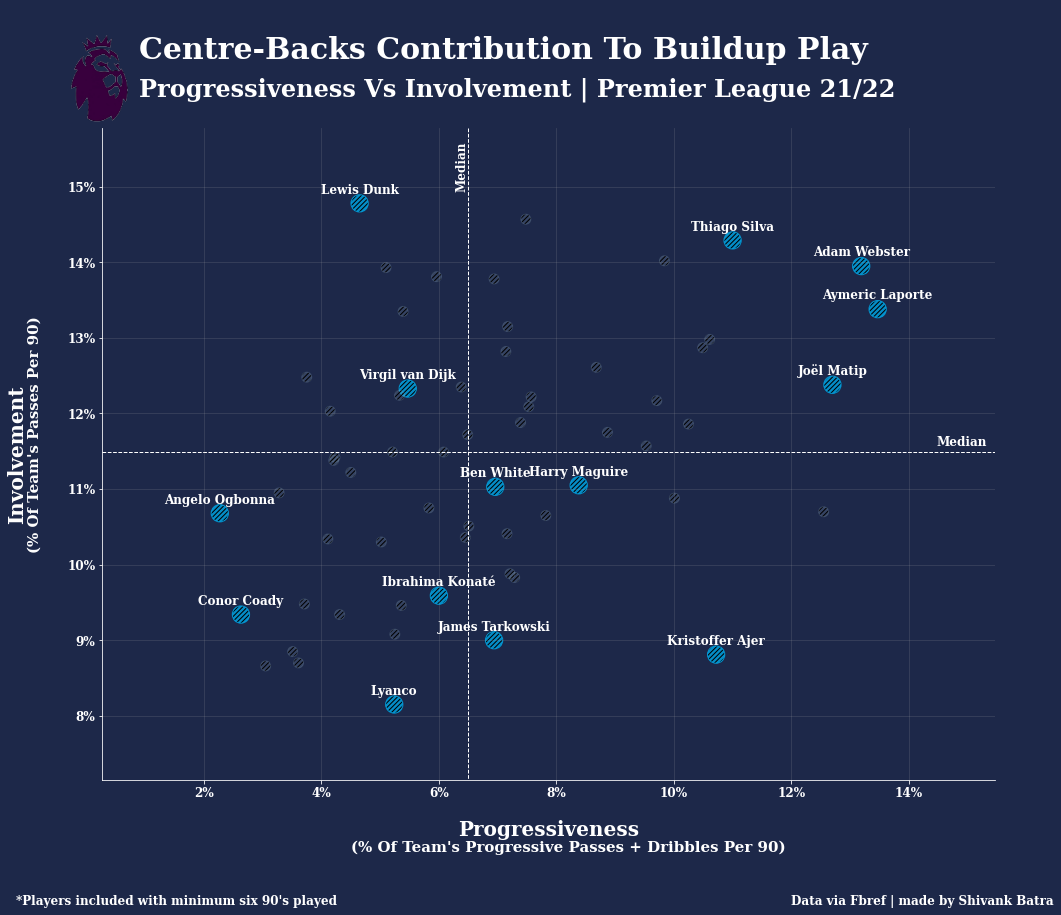

In [86]:
scatterplot(prem_df, highlight_names)